## Introduction

This report develops on the work carried out in Part 1, focusing on two main features:

* How do mosquito numbers vary throughout the year and how can we predict this?
* How can we predict the likelihood of a mosquito being WNV positive based on a number of variables?


### Data dictionary

#### Column Information

**Year**-- Year that the WNV test is performed --	int64	

**Week**-- Week that the WNV test is performed	-- int64	

**Address Block** -- Address of the location of trap. -- string	

**Block** -- Block number of address -- int64

**Trap** -- Id of the trap -- string **NOTE** Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are post fixed with letters. For example, T220A is a satellite trap to T220.

**Trap type** -- Type of trap -- string	

**Date** -- Date and time that the WNV test is performed -- string	**NOTE** Not all the locations are tested at all times. Also, records exist only when a particular species of mosquitoes is found at a certain trap at a certain time.


**Mosquito number** -- Number of mosquitoes caught in this trap -- int64 **NOTE** These test results are organized in such a way that when the number of mosquitoes exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitoes are capped at 50.

**Mosquito ID**	-- Id for Mosquito species -- string

**WNV Present** -- Whether West Nile Virus was present in these mosquitos -- string		

**Species** -- Mosquito species -- string

**Lat** -- Latitude of trap -- float64		

**Lon** -- Longitude of trap -- float64

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

## Utility Functions

In [2]:
def basic_eda(df_clean,df_clean_name):
    """
    Summary: This function summarises key metrics regarding a dataset, to be used in the data checking phase, 
    including the % of null and duplicate rows. 
    
    Inputs: df_clean = dataframe to check.
            df_clean_name = name of the dataframe to check.
            
    Outputs: - Number of Rows/Columns.
             - Percentage of null rows
             - Percentage of duplicate rows
             - Data types
    
    """
    print(df_clean_name.upper())
    print()
    print(f'Rows: {df_clean.shape[0]} \t Columnss: {df_clean.shape[1]}')
    
    print(f'Total null rows: {df_clean.isnull().sum().sum()}')
    print(f'Percentage null rows: {round(df_clean.isnull().sum().sum()/df_clean.shape[0]* 100,2)}%')
    print()
    
    print(f"Total duplicate rows: {df_clean[df_clean.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df_clean[df_clean.duplicated(keep=False)].shape[0]/df_clean.shape[0]*100,2)}%")
    print()
    
    print(df_clean.dtypes)
    print("----\n");

In [3]:
#Fit logistic model
def fit_logit_model(X,y):
    """
    Summary: Add constant column to predictor dataframe. Instantiate logistic model. Fit logistic model to data. 

    Inputs: X = dataframe of predictor variables
            y = target variable
            
    Outputs: A logistic model fitted to the test data.
    """
    # add constant
    X_const = sm.add_constant(X)

    # instantiate model
    logit_mod = sm.Logit(y, X_const)

    # fit model
    logit_mod_fitted = logit_mod.fit()
    
    return X_const, logit_mod_fitted

In [4]:
#Model accuracy
def logit_accuracy(X_cons,y,logit_fitted):
    """
    Summary: This function predicts the accuracy of a given logistic model.
    
    Inputs: X_cons       = dataframe of predictor variables with real values
            y            = target variable with real values
            logit_fitted = logistic regression model to test
            
    Output: A % of the accuracy at which the model correctly matches with the real data.
            
    """
    y_probs = logit_fitted.predict(X_cons)
    # Convert those to hard predictions. 
    y_pred = np.where(y_probs >= 0.5, 1, 0)
    # Cross-check against the real y values.
    num_correct = (y_pred ==y).sum()
    # Calculate as a percentage
    percent_accuracy = num_correct/X_cons.shape[0]*100
    
    print(f'The model performs with an accuracy = {percent_accuracy.round(2)}%')

## Importing Data

In [5]:
df_clean = pd.read_csv('data/clean/mosquito_data_part_2.csv')
df_clean.head(10)

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9
5,2019,39,21XX N CANNON DR,T054C,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.921777,-87.632140,9
6,2019,39,11XX W ROOSEVELT RD,T048,GRAVID,2019-09-26 00:09:00,3,negative,CULEX RESTUANS,41.866915,-87.654919,9
7,2019,39,22XX W 51ST ST,T061,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.801048,-87.680425,9
8,2019,39,22XX N CANNON DR,T054A,GRAVID,2019-09-26 00:09:00,1,negative,CULEX TERRITANS,41.922737,-87.632450,9
9,2019,39,3XX W 104TH ST,T095,GRAVID,2019-09-26 00:09:00,1,negative,CULEX SALINARIUS,41.705328,-87.632955,9


In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Week             18495 non-null  int64  
 2   Address Block    18495 non-null  object 
 3   Trap             18495 non-null  object 
 4   Trap type        18495 non-null  object 
 5   Date             18495 non-null  object 
 6   Mosquito number  18495 non-null  int64  
 7   WNV Present      18495 non-null  object 
 8   Species          18495 non-null  object 
 9   Lat              18495 non-null  float64
 10  Lon              18495 non-null  float64
 11  Month            18495 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1.7+ MB


In [7]:
df_clean.describe()

,Year,Week,Mosquito number,Lat,Lon,Month
count,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000,18495.000000
mean,2012.905812,31.004001,10.879913,41.852599,-87.712611,7.627088
std,3.725857,4.332020,13.475066,0.115419,0.095409,0.998079
min,2007.000000,20.000000,1.000000,41.644720,-87.880969,5.000000
25%,2010.000000,28.000000,2.000000,41.754148,-87.778235,7.000000
50%,2013.000000,31.000000,5.000000,41.872873,-87.703105,8.000000
75%,2016.000000,34.000000,14.000000,41.970102,-87.643076,8.000000
max,2019.000000,40.000000,50.000000,42.017801,-87.531051,10.000000


In [8]:
df_clean_raw = pd.read_csv('data/raw/mosquito_data.csv')
df_cleans = [(df_clean,'clean data'),(df_clean_raw,'raw data')]

[basic_eda(i,j) for i,j in df_cleans];

CLEAN DATA

Rows: 18495 	 Columnss: 12
Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 862
Percentage dupe rows: 4.66%

Year                 int64
Week                 int64
Address Block       object
Trap                object
Trap type           object
Date                object
Mosquito number      int64
WNV Present         object
Species             object
Lat                float64
Lon                float64
Month                int64
dtype: object
----

RAW DATA

Rows: 18495 	 Columnss: 13
Total null rows: 5848
Percentage null rows: 31.62%

Total duplicate rows: 862
Percentage dupe rows: 4.66%

Year                 int64
Week                 int64
Address Block       object
Block                int64
Trap                object
Trap type           object
Date                object
Mosquito number      int64
Mosquito ID         object
WNV Present         object
Species             object
Lat                float64
Lon                float64
dtype: object
----



On the whole, the cleaned data set looks good. The null rows have been removed, and the duplicate rows have been kept, as for some locations multiple traps exist (Ohare Airport).

## Preprocessing

In [9]:
num_col_list = list(df_clean.select_dtypes('number'))
obj_col_list = list(df_clean.select_dtypes('object'))

print(f'Numerical columns:\n',',\n'.join(num_col_list))
print('\n')
print(f'Object columns:\n',',\n'.join(obj_col_list))

Numerical columns:
 Year,
Week,
Mosquito number,
Lat,
Lon,
Month


Object columns:
 Address Block,
Trap,
Trap type,
Date,
WNV Present,
Species


In [10]:
df_clean_num = df_clean[num_col_list].copy()
df_clean_num.head()

,Year,Week,Mosquito number,Lat,Lon,Month
0,2019,39,2,41.977738,-87.880969,9
1,2019,39,1,41.798211,-87.736925,9
2,2019,39,2,41.987245,-87.689417,9
3,2019,39,1,41.953664,-87.724987,9
4,2019,39,9,41.657069,-87.546049,9


In [11]:
df_clean_obj = df_clean[obj_col_list].copy()
df_clean_obj.head()

,Address Block,Trap,Trap type,Date,WNV Present,Species
0,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS
1,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS
2,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS
3,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS
4,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS


The data has now been sorted into numerical, object and datetime dataframes. The first task is to identify which of the object columns can be turned into numerical, to allow for them to be used as features in upcoming models. 

### Preprocessing `Address Block`

The Address Block contains information that could be represented quantitatively (the Block number within the address block). This is to be extracted and placed in a new column.

In [12]:
df_clean_obj['Address Block']

0         100XX W OHARE AIRPORT
1             52XX S KOLMAR AVE
2            58XX N WESTERN AVE
3        39XX N SPRINGFIELD AVE
4           131XX S BRANDON AVE
                  ...          
18490             3XX W 18TH ST
18491      46XX N MILWAUKEE AVE
18492          127XX S DOTY AVE
18493        20XX N DOMINICK ST
18494     100XX W OHARE AIRPORT
Name: Address Block, Length: 18495, dtype: object

In [13]:
expression = '^([0-9]+)[A-Z]{2}'
df_clean_num['Block Number'] = df_clean_obj['Address Block'].str.extract(expression)

In [14]:
df_clean_num.head()

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number
0,2019,39,2,41.977738,-87.880969,9,100
1,2019,39,1,41.798211,-87.736925,9,52
2,2019,39,2,41.987245,-87.689417,9,58
3,2019,39,1,41.953664,-87.724987,9,39
4,2019,39,9,41.657069,-87.546049,9,131


It may also be useful to know if the North, South, East or West aspect of the Address is useful. This is also extracted from the address block to create a new Object column. 

In [15]:
expression = '([NSEW]\s)'
df_clean_obj['Block Direction']=df_clean_obj['Address Block'].str.extract(expression)
df_clean_obj

,Address Block,Trap,Trap type,Date,WNV Present,Species,Block Direction
0,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,W
1,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,S
2,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,N
3,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,N
4,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,S
...,...,...,...,...,...,...,...
18490,3XX W 18TH ST,T043,GRAVID,2016-09-09 00:09:00,positive,CULEX PIPIENS,W
18491,46XX N MILWAUKEE AVE,T003,GRAVID,2007-08-24 00:08:00,positive,CULEX PIPIENS,N
18492,127XX S DOTY AVE,T115,GRAVID,2016-07-27 00:07:00,positive,CULEX RESTUANS,S
18493,20XX N DOMINICK ST,T240B,SENTINEL,2017-08-17 00:08:00,positive,CULEX RESTUANS,N


It is more useful to have the Block Direction as a Dummy variable so we can see if there are correlations with the variable.

In [16]:
df_clean_num = pd.concat([df_clean_num, pd.get_dummies(df_clean_obj['Block Direction'],prefix = 'Block_direction')], axis=1)

In [17]:
df_clean_num['Block Number'] = df_clean_num['Block Number'].astype(int)

In [18]:
df_clean_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                18495 non-null  int64  
 1   Week                18495 non-null  int64  
 2   Mosquito number     18495 non-null  int64  
 3   Lat                 18495 non-null  float64
 4   Lon                 18495 non-null  float64
 5   Month               18495 non-null  int64  
 6   Block Number        18495 non-null  int64  
 7   Block_direction_E   18495 non-null  uint8  
 8   Block_direction_N   18495 non-null  uint8  
 9   Block_direction_S   18495 non-null  uint8  
 10  Block_direction_W   18495 non-null  uint8  
dtypes: float64(2), int64(5), uint8(4)
memory usage: 1.1 MB


The 'Trap' Column can not be converted to a quantitative column with any meaning. This column will be dropped eventually. 

### Preprocessing `WNV Present`

The WNV Present column needs to be transformed to a binary column. The below code converts all 'positive' to a 1, and 'negative' to a 0 in the WNV column.

In [19]:
df_clean_obj['WNV Present'].value_counts()

negative    14501
positive     3994
Name: WNV Present, dtype: int64

In [20]:
df_clean_num['WNV Present'] = df_clean_obj['WNV Present'].map({'positive': 1, 'negative':0})

# .eq returns a Series of boolean True or Fasle depending on if the value in WNV Present column is 'positive'.
# .mul(1) then converts the Trues to a 1 and the False to a 0.

In [21]:
df_clean_num['WNV Present'].value_counts()

0    14501
1     3994
Name: WNV Present, dtype: int64

In [22]:
df_clean_num.head()

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_E,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present
0,2019,39,2,41.977738,-87.880969,9,100,0,0,0,1,0
1,2019,39,1,41.798211,-87.736925,9,52,0,0,1,0,0
2,2019,39,2,41.987245,-87.689417,9,58,0,1,0,0,0
3,2019,39,1,41.953664,-87.724987,9,39,0,1,0,0,0
4,2019,39,9,41.657069,-87.546049,9,131,0,0,1,0,0


### Preprocessing `Trap type`

The Trap Type column needs to be converted to dummy variables, to all for them to be used in our models.

In [23]:
df_clean_obj['Trap type'].value_counts()

GRAVID      17741
CDC           544
SENTINEL      209
OVI             1
Name: Trap type, dtype: int64

There are 4 unique trap types. These are to be converted to dummy variable columns.

In [24]:
df_clean_num = pd.concat([df_clean_num, pd.get_dummies(df_clean_obj['Trap type'], prefix='Trap_type')], axis=1)

In [25]:
df_clean_num.head()

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_E,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_OVI,Trap_type_SENTINEL
0,2019,39,2,41.977738,-87.880969,9,100,0,0,0,1,0,0,1,0,0
1,2019,39,1,41.798211,-87.736925,9,52,0,0,1,0,0,0,1,0,0
2,2019,39,2,41.987245,-87.689417,9,58,0,1,0,0,0,0,1,0,0
3,2019,39,1,41.953664,-87.724987,9,39,0,1,0,0,0,0,1,0,0
4,2019,39,9,41.657069,-87.546049,9,131,0,0,1,0,0,0,1,0,0


### Preprocessing `Species`

In [26]:
df_clean_num = pd.concat([df_clean_num, pd.get_dummies(df_clean_obj['Species'],prefix = 'Species')], axis=1)

In [27]:
df_clean_num.head()

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_E,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_OVI,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TERRITANS
0,2019,39,2,41.977738,-87.880969,9,100,0,0,0,1,0,0,1,0,0,0,1,0,0
1,2019,39,1,41.798211,-87.736925,9,52,0,0,1,0,0,0,1,0,0,0,1,0,0
2,2019,39,2,41.987245,-87.689417,9,58,0,1,0,0,0,0,1,0,0,0,1,0,0
3,2019,39,1,41.953664,-87.724987,9,39,0,1,0,0,0,0,1,0,0,0,1,0,0
4,2019,39,9,41.657069,-87.546049,9,131,0,0,1,0,0,0,1,0,0,0,1,0,0


In [28]:
df_clean_num.nunique().sort_values()

Block_direction_S              2
Species_CULEX RESTUANS         2
Species_CULEX PIPIENS          2
Trap_type_SENTINEL             2
Trap_type_OVI                  2
Trap_type_GRAVID               2
Trap_type_CDC                  2
WNV Present                    2
Block_direction_W              2
Species_CULEX TERRITANS        2
Block_direction_N              2
Block_direction_E              2
Species_CULEX SALINARIUS       2
Month                          6
Year                          13
Week                          21
Mosquito number               50
Block Number                  87
Lon                         2509
Lat                         2509
dtype: int64

### Preprocessing `Date`

The data is more useful as a Datetime object, and so the below code converts it.

In [29]:
df_clean_obj

,Address Block,Trap,Trap type,Date,WNV Present,Species,Block Direction
0,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,W
1,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,S
2,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,N
3,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,N
4,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,S
...,...,...,...,...,...,...,...
18490,3XX W 18TH ST,T043,GRAVID,2016-09-09 00:09:00,positive,CULEX PIPIENS,W
18491,46XX N MILWAUKEE AVE,T003,GRAVID,2007-08-24 00:08:00,positive,CULEX PIPIENS,N
18492,127XX S DOTY AVE,T115,GRAVID,2016-07-27 00:07:00,positive,CULEX RESTUANS,S
18493,20XX N DOMINICK ST,T240B,SENTINEL,2017-08-17 00:08:00,positive,CULEX RESTUANS,N


In [30]:
df_clean_obj['Date'] = pd.to_datetime(df_clean_obj['Date'])
df_clean_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Address Block    18495 non-null  object        
 1   Trap             18495 non-null  object        
 2   Trap type        18495 non-null  object        
 3   Date             18495 non-null  datetime64[ns]
 4   WNV Present      18495 non-null  object        
 5   Species          18495 non-null  object        
 6   Block Direction  18495 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 1011.6+ KB


All of the relevant categorical columns are now converted to numerical. Going forward, the `df_clean_num` and `df_clean_obj` dataframes are to be used.

The Date column will be more useful if it is binned into Quarters of the year.

In [31]:
df_clean_num['Yearly_quarter']=df_clean_obj['Date'].dt.quarter

In [32]:
df_clean_num.head(5)

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_E,Block_direction_N,Block_direction_S,...,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_OVI,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TERRITANS,Yearly_quarter
0,2019,39,2,41.977738,-87.880969,9,100,0,0,0,...,0,0,1,0,0,0,1,0,0,3
1,2019,39,1,41.798211,-87.736925,9,52,0,0,1,...,0,0,1,0,0,0,1,0,0,3
2,2019,39,2,41.987245,-87.689417,9,58,0,1,0,...,0,0,1,0,0,0,1,0,0,3
3,2019,39,1,41.953664,-87.724987,9,39,0,1,0,...,0,0,1,0,0,0,1,0,0,3
4,2019,39,9,41.657069,-87.546049,9,131,0,0,1,...,0,0,1,0,0,0,1,0,0,3


In [33]:
df_clean_obj.head()

,Address Block,Trap,Trap type,Date,WNV Present,Species,Block Direction
0,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,W
1,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,S
2,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,N
3,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,N
4,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,negative,CULEX RESTUANS,S


NOTE: where dummy variables have been created, one of each dummy category should be dropped, to avoid issues of multicollinearity further down the line, and avoid unnecessary data in the data frame.

In [34]:
df_clean_num.sum().sort_values(ascending=False)

Year                        3.722869e+07
Block Number                1.004552e+06
Lat                         7.740638e+05
Week                        5.734190e+05
Mosquito number             2.012240e+05
Month                       1.410630e+05
Yearly_quarter              5.288100e+04
Trap_type_GRAVID            1.774100e+04
Species_CULEX RESTUANS      1.186600e+04
Block_direction_W           6.887000e+03
Species_CULEX PIPIENS       5.486000e+03
Block_direction_S           5.366000e+03
Block_direction_N           4.992000e+03
WNV Present                 3.994000e+03
Block_direction_E           1.250000e+03
Species_CULEX TERRITANS     9.170000e+02
Trap_type_CDC               5.440000e+02
Species_CULEX SALINARIUS    2.260000e+02
Trap_type_SENTINEL          2.090000e+02
Trap_type_OVI               1.000000e+00
Lon                        -1.622245e+06
dtype: float64

In [35]:
# Dropping 1 of each dummy variable
df_clean_num = df_clean_num.drop(columns =['Block_direction_E ','Trap_type_OVI', 'Species_CULEX SALINARIUS'])


#### Looking at how the number of mosquitos varies for each month...

In [36]:
df_clean_num_means = df_clean_num.groupby(df_clean_num['Month']).mean()
df_clean_num_means

,Year,Week,Mosquito number,Lat,Lon,Block Number,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS,Yearly_quarter
Month,,,,,,,,,,,,,,,,,
5,2008.238095,20.380952,2.761905,41.824481,-87.685189,46.595238,0.238095,0.238095,0.452381,0.000000,0.095238,0.904762,0.000000,0.095238,0.904762,0.000000,2.0
6,2013.708647,24.202009,10.264442,41.854124,-87.712200,53.685325,0.265160,0.290994,0.383925,0.015788,0.008611,0.988518,0.002512,0.041981,0.902045,0.045928,2.0
7,2013.032498,28.498825,11.551879,41.854573,-87.714573,55.289154,0.265466,0.287392,0.376468,0.163469,0.019186,0.970634,0.010180,0.169734,0.771339,0.043070,3.0
8,2012.739232,32.490541,12.111321,41.851121,-87.712942,54.303551,0.271682,0.290308,0.371944,0.358411,0.039290,0.947177,0.013533,0.407742,0.533178,0.046566,3.0
9,2012.707599,36.822595,8.394973,41.853631,-87.711043,53.564866,0.279688,0.287200,0.361456,0.186362,0.035250,0.948281,0.016469,0.443802,0.480208,0.067322,3.0
10,2009.093333,39.208889,5.377778,41.823429,-87.692313,53.311111,0.231111,0.391111,0.302222,0.031111,0.115556,0.884444,0.000000,0.711111,0.213333,0.071111,4.0


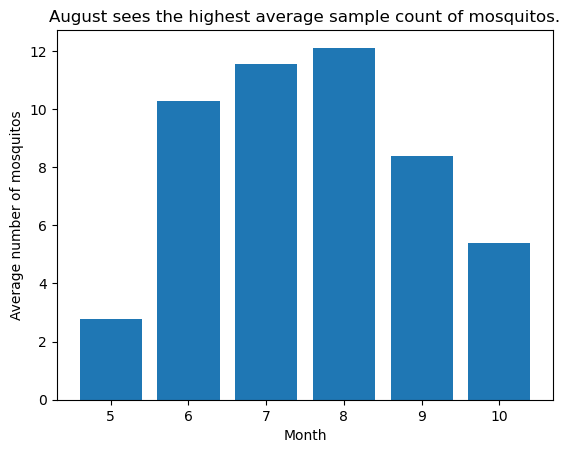

In [37]:
plt.figure()
plt.bar(df_clean_num_means.index,df_clean_num_means['Mosquito number'])
plt.xlabel('Month')
plt.ylabel('Average number of mosquitos')
plt.title('August sees the highest average sample count of mosquitos.');

The above graph show the average sample size taken for each month between 2007 and 2019. It would be usesful to also look at the *total* number of mosquitos recorded for each month.

In [38]:
df_clean_num

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS,Yearly_quarter
0,2019,39,2,41.977738,-87.880969,9,100,0,0,1,0,0,1,0,0,1,0,3
1,2019,39,1,41.798211,-87.736925,9,52,0,1,0,0,0,1,0,0,1,0,3
2,2019,39,2,41.987245,-87.689417,9,58,1,0,0,0,0,1,0,0,1,0,3
3,2019,39,1,41.953664,-87.724987,9,39,1,0,0,0,0,1,0,0,1,0,3
4,2019,39,9,41.657069,-87.546049,9,131,0,1,0,0,0,1,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18490,2016,36,4,41.857843,-87.635858,9,3,0,0,1,1,0,1,0,1,0,0,3
18491,2007,34,19,41.965376,-87.758403,8,46,1,0,0,1,0,1,0,1,0,0,3
18492,2016,30,34,41.662395,-87.590176,7,127,0,1,0,1,0,1,0,0,1,0,3
18493,2017,33,50,41.919197,-87.664758,8,20,1,0,0,1,0,0,1,0,1,0,3


In [39]:
df_clean_num_totals_groupby_year = pd.concat([df_clean_num,df_clean_obj['Date']],axis =1)
df_clean_num_totals_groupby_year  = df_clean_num_totals_groupby_year.groupby(['Year','Month']).sum()
df_clean_num_totals_groupby_year.head(15)

Week  Mosquito number           Lat            Lon  Block Number  \
Year Month                                                                      
2007 5        336               30    669.509126   -1402.964359           537   
     6       2579              307   4690.493905   -9823.673196          4574   
     7       7114             1376  10962.909939  -22974.494424         14160   
     8      38881            18936  51585.964028 -108190.113571         69924   
     9      14429             3521  16646.016680  -34896.494124         21652   
     10      4641              924   4976.403846  -10434.422999          6017   
2008 6       3113              461   5394.651485  -11311.978909          7427   
     7       8898             1426  13179.792105  -27627.541876         18592   
     8      12066             1412  15478.854517  -32447.110011         19476   
     9       6129              583   7118.190277  -14912.570525          9531   
2009 5        520               86   1087.119082   -2279.813586          1420   
     6       6610             1992  12011.177267  -25172.121808         15052   
     7      11194             2245  16654.466733  -34908.524248         22558   
     8       5922              675   7741.808775  -16228.788990         10913   
     9       7483              450   8535.761257  -17891.945267         11606   

            Block_direction_N   Block_direction_S   Block_direction_W   \
Year Month                                                               
2007 5                     5.0                 2.0                 9.0   
     6                    48.0                15.0                48.0   
     7                    80.0                75.0                87.0   
     8                   266.0               492.0               358.0   
     9                    99.0               148.0               124.0   
     10                   28.0                48.0                34.0   
2008 6                    33.0                50.0                35.0   
     7                    80.0               106.0               109.0   
     8                    89.0               123.0               130.0   
     9                    60.0                48.0                55.0   
2009 5                     5.0                 8.0                10.0   
     6                    82.0                94.0                98.0   
     7                   103.0               126.0               143.0   
     8                    43.0                50.0                78.0   
     9                    53.0                68.0                64.0   

            WNV Present  Trap_type_CDC  Trap_type_GRAVID  Trap_type_SENTINEL  \
Year Month                                                                     
2007 5                0            4.0              12.0                 0.0   
     6                0           20.0              91.0                 0.0   
     7                3           75.0             187.0                 0.0   
     8              406          247.0             987.0                 0.0   
     9               59          107.0             291.0                 0.0   
     10               7           25.0              94.0                 0.0   
2008 6                0            2.0             127.0                 0.0   
     7                2            5.0             310.0                 0.0   
     8               12            2.0             368.0                 0.0   
     9                7            2.0             168.0                 0.0   
2009 5                0            0.0              26.0                 0.0   
     6                0            1.0             286.0                 0.0   
     7                5            9.0             389.0                 0.0   
     8                8            9.0             176.0                 0.0   
     9                7            6.0             198.0                 0.0   

            Spe

In [40]:
df_clean_num_totals_groupby_month = df_clean_num_totals_groupby_year.groupby('Month').mean()

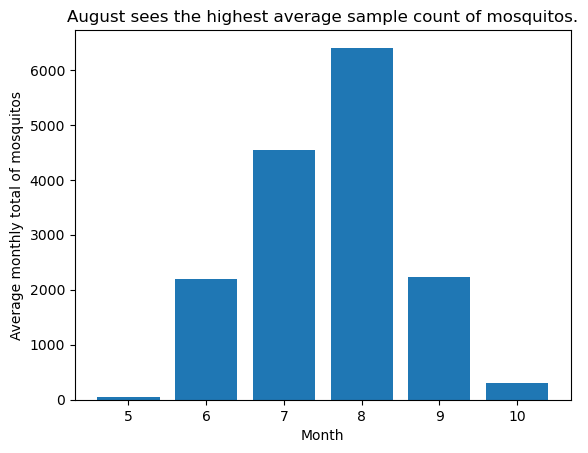

In [41]:
plt.figure()
plt.bar(df_clean_num_totals_groupby_month.index,df_clean_num_totals_groupby_month['Mosquito number'])
plt.xlabel('Month')
plt.ylabel('Average monthly total of mosquitos')
plt.title('August sees the highest average sample count of mosquitos.');

By looking at the bar chart above and comparing against the initial bar chart (showing the *mean* sample size for each month), you get a clearer picture of the monthly totals. This confirms the fact that mosquito numbers increase over summer and plummet over the winter (assuming that the trend continues for the months with no data. This assumption is based on it being likely no data is recorded because mosquito numbers were negligible).

In [42]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             18495 non-null  int64         
 1   Week             18495 non-null  int64         
 2   Address Block    18495 non-null  object        
 3   Trap             18495 non-null  object        
 4   Trap type        18495 non-null  object        
 5   Date             18495 non-null  datetime64[ns]
 6   Mosquito number  18495 non-null  int64         
 7   WNV Present      18495 non-null  object        
 8   Species          18495 non-null  object        
 9   Lat              18495 non-null  float64       
 10  Lon              18495 non-null  float64       
 11  Month            18495 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 1.7+ MB


## Statistical analysis of Species vs Occurence of WNV

The first task is to gain a high level overview of the number of positive cases for the different species.

In [43]:
df_clean_species_wnv = pd.concat([df_clean_num, df_clean_obj['Species']],axis = 1)
df_clean_species_wnv.head(5)

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS,Yearly_quarter,Species
0,2019,39,2,41.977738,-87.880969,9,100,0,0,1,0,0,1,0,0,1,0,3,CULEX RESTUANS
1,2019,39,1,41.798211,-87.736925,9,52,0,1,0,0,0,1,0,0,1,0,3,CULEX RESTUANS
2,2019,39,2,41.987245,-87.689417,9,58,1,0,0,0,0,1,0,0,1,0,3,CULEX RESTUANS
3,2019,39,1,41.953664,-87.724987,9,39,1,0,0,0,0,1,0,0,1,0,3,CULEX RESTUANS
4,2019,39,9,41.657069,-87.546049,9,131,0,1,0,0,0,1,0,0,1,0,3,CULEX RESTUANS


In [44]:
df_clean_species_wnv_grouped = df_clean_species_wnv.groupby('Species').sum()
df_clean_species_wnv_grouped

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS,Yearly_quarter
Species,,,,,,,,,,,,,,,,,,
CULEX PIPIENS,11031861,181681,61364,229552.293819,-4.811737e+05,44631,308051,1398.0,1696.0,1976.0,1412,388.0,5079.0,18.0,5486.0,0.0,0.0,16497
CULEX RESTUANS,23896504,355768,137586,496701.411606,-1.040845e+06,87604,638364,3339.0,3272.0,4536.0,2557,124.0,11555.0,187.0,0.0,11866.0,0.0,33094
CULEX SALINARIUS,454413,6902,464,9457.658264,-1.982387e+04,1703,12994,46.0,55.0,100.0,11,20.0,205.0,1.0,0.0,0.0,0.0,651
CULEX TERRITANS,1845915,29068,1810,38352.455480,-8.040253e+04,7125,45143,209.0,343.0,275.0,14,12.0,902.0,3.0,0.0,0.0,917.0,2639


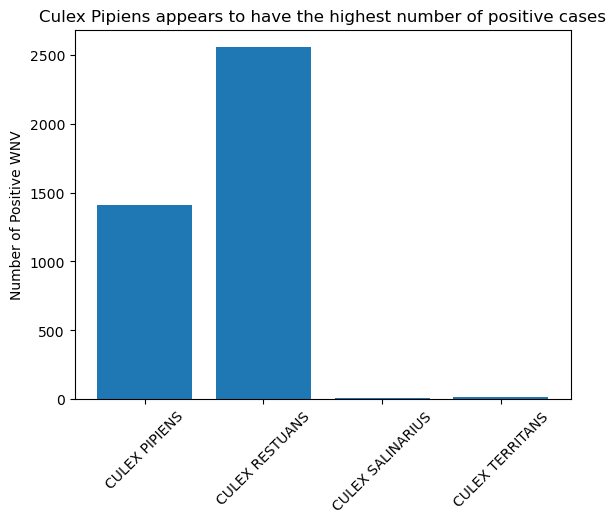

In [45]:
plt.figure()
plt.bar(df_clean_species_wnv_grouped.index, (df_clean_species_wnv_grouped['WNV Present']))
plt.ylabel('Number of Positive WNV')
plt.xticks(rotation = 45)
plt.title('Culex Pipiens appears to have the highest number of positive cases');

The above shows there to be big gap between the no. of positive cases in Culex Pipiens and Culex Restuans when compared to Culex Salinarius and Culex Territans. At this stage, it is unknown if this difference is by chance, and so a statistical test needs to be carried out to see if the number of positive/negative cases is independent of the Species or not. 

HYPOTHESES:

H0 = There is no relationship between the Species and the number of Positive and Negative cases.

H1 = There is a relationship between the Species and the number of Positive and Negative cases.

In [46]:
df_clean_species_wnv2 = df_clean_species_wnv.copy()
total_pos =  df_clean_species_wnv2.groupby('Species').sum()['WNV Present']
total_neg = df_clean_species_wnv2.groupby('Species').count()['WNV Present']-total_pos

In [47]:
df_clean_species_wnv_grouped['Positive Count'] = total_pos
df_clean_species_wnv_grouped['Negative Count'] = total_neg
chi_squ_ind_tab = df_clean_species_wnv_grouped[['Positive Count','Negative Count']]
chi_squ_ind_tab

,Positive Count,Negative Count
Species,,
CULEX PIPIENS,1412,4074
CULEX RESTUANS,2557,9309
CULEX SALINARIUS,11,215
CULEX TERRITANS,14,903


The above table is now ready to perform a Chi Squared Independence Test.

In [48]:
stats.chi2_contingency(chi_squ_ind_tab)

(311.10394683130164,
 3.9302341764409087e-67,
 3,
 array([[1184.70310895, 4301.29689105],
        [2562.4657475 , 9303.5342525 ],
        [  48.80475804,  177.19524196],
        [ 198.02638551,  718.97361449]]))

The p- value of 0 < 0.05 and therefore we can reject the null hypothesis that mosquito species and number of positive/negative cases are independent. It appears that there is some relationship between species and no. of positive cases.

The above test is useful, but it would be more interesting to see if there is a statistical difference between the proportion of positive Pipiens vs the proportion of positive Restuans. A z-test will allow us to determine this.

HYPOTHESES:

H0 = There is no difference between the proportion of positive cases for Pipiens vs Restuans.

H1 = There is a difference between the proportion of positive cases for Pipiens vs Restuans.

In [49]:
df_clean_species_wnv.groupby('Species').mean()['WNV Present']

Species
CULEX PIPIENS       0.257382
CULEX RESTUANS      0.215490
CULEX SALINARIUS    0.048673
CULEX TERRITANS     0.015267
Name: WNV Present, dtype: float64

The above shows the proportion of positive Culex Pipiens = 0.257 and the proportion of positive Culex Restuans = 0.215.

In [50]:
df_clean_props = df_clean_species_wnv.groupby('Species').sum()[['Mosquito number','WNV Present']]

In [51]:
df_clean_props 

,Mosquito number,WNV Present
Species,,
CULEX PIPIENS,61364,1412
CULEX RESTUANS,137586,2557
CULEX SALINARIUS,464,11
CULEX TERRITANS,1810,14


In [52]:
# proportions z test is located inside statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [53]:
# Getting a statistic and p-value for the hypothesis test using the data above
pipiens_count = df_clean_props.iloc[0,1]
restuans_count = df_clean_props.iloc[1,1]
pipiens_obs_num = df_clean_props.iloc[0,0]
restuans_obs_num = df_clean_props.iloc[1,0]

# these are the counts of review writing in Scenario A and B
counts = [pipiens_count,restuans_count]
# these are the counts of emails sent out in Scenario A and B
number_of_obs = [pipiens_obs_num,restuans_obs_num]

# test
proportions_ztest(counts, number_of_obs)

(6.519901175188535, 7.035372869182627e-11)

The above Z-test gives a p-value of 7.04e-11 << 0.05 and therefore we can reject the null hypothesis. Hence, there is a statistically significant difference between the proportion of positive cases for Restuans and Pipiens. Hence, we canc confidently say that Culex Pipiens is the most likely to carry the WNV.

## Exploring significant correlations

In [54]:
df_clean_num.head(5)

,Year,Week,Mosquito number,Lat,Lon,Month,Block Number,Block_direction_N,Block_direction_S,Block_direction_W,WNV Present,Trap_type_CDC,Trap_type_GRAVID,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS,Yearly_quarter
0,2019,39,2,41.977738,-87.880969,9,100,0,0,1,0,0,1,0,0,1,0,3
1,2019,39,1,41.798211,-87.736925,9,52,0,1,0,0,0,1,0,0,1,0,3
2,2019,39,2,41.987245,-87.689417,9,58,1,0,0,0,0,1,0,0,1,0,3
3,2019,39,1,41.953664,-87.724987,9,39,1,0,0,0,0,1,0,0,1,0,3
4,2019,39,9,41.657069,-87.546049,9,131,0,1,0,0,0,1,0,0,1,0,3


In [55]:
df_clean_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     18495 non-null  int64  
 1   Week                     18495 non-null  int64  
 2   Mosquito number          18495 non-null  int64  
 3   Lat                      18495 non-null  float64
 4   Lon                      18495 non-null  float64
 5   Month                    18495 non-null  int64  
 6   Block Number             18495 non-null  int64  
 7   Block_direction_N        18495 non-null  uint8  
 8   Block_direction_S        18495 non-null  uint8  
 9   Block_direction_W        18495 non-null  uint8  
 10  WNV Present              18495 non-null  int64  
 11  Trap_type_CDC            18495 non-null  uint8  
 12  Trap_type_GRAVID         18495 non-null  uint8  
 13  Trap_type_SENTINEL       18495 non-null  uint8  
 14  Species_CULEX PIPIENS 

In [56]:
df_clean_num.nunique().sort_values()

Block_direction_S             2
Species_CULEX RESTUANS        2
Species_CULEX PIPIENS         2
Trap_type_SENTINEL            2
Trap_type_GRAVID              2
Trap_type_CDC                 2
WNV Present                   2
Block_direction_N             2
Species_CULEX TERRITANS       2
Block_direction_W             2
Yearly_quarter                3
Month                         6
Year                         13
Week                         21
Mosquito number              50
Block Number                 87
Lon                        2509
Lat                        2509
dtype: int64

The Month is considered in the Yearly_quarter column and so 'Month' is dropped from the data frame at this point.

In [57]:
df_clean_num = df_clean_num.drop(columns = 'Month')

In [58]:
y = df_clean_num['Mosquito number'].copy() # dependent variable
X = df_clean_num.drop('Mosquito number', axis =1) # only numerical columns selected

In [59]:
df_pearson = pd.DataFrame(columns = ['Variable','Pearson_correlation','P_value'])
i = 0
for x in X:
    pearson = stats.pearsonr(y,df_clean_num[x])
    df_pearson.loc[i,'Variable'] = x
    df_pearson.loc[i,'Pearson_correlation'] = pearson[0]
    df_pearson.loc[i,'P_value'] = pearson[1]
    i = i + 1

In [60]:
df_pearson.set_index('Variable',inplace=True)

In [61]:
df_pearson.sort_values('Pearson_correlation', ascending=False, inplace=True)
df_pearson

,Pearson_correlation,P_value
Variable,,
WNV Present,0.408034,0.0
Year,0.129326,0.0
Block Number,0.121259,0.0
Trap_type_SENTINEL,0.108575,0.0
Lat,0.09682,0.0
Trap_type_CDC,0.094147,0.0
Species_CULEX RESTUANS,0.070999,0.0
Block_direction_N,0.050488,0.0
Species_CULEX PIPIENS,0.01473,0.045152


The above provides the Pearson Correlation score between the various numerical independent variables and the target variable 'Mosquito Number', as well as the p-value. The relationships are visualised graphically below. 

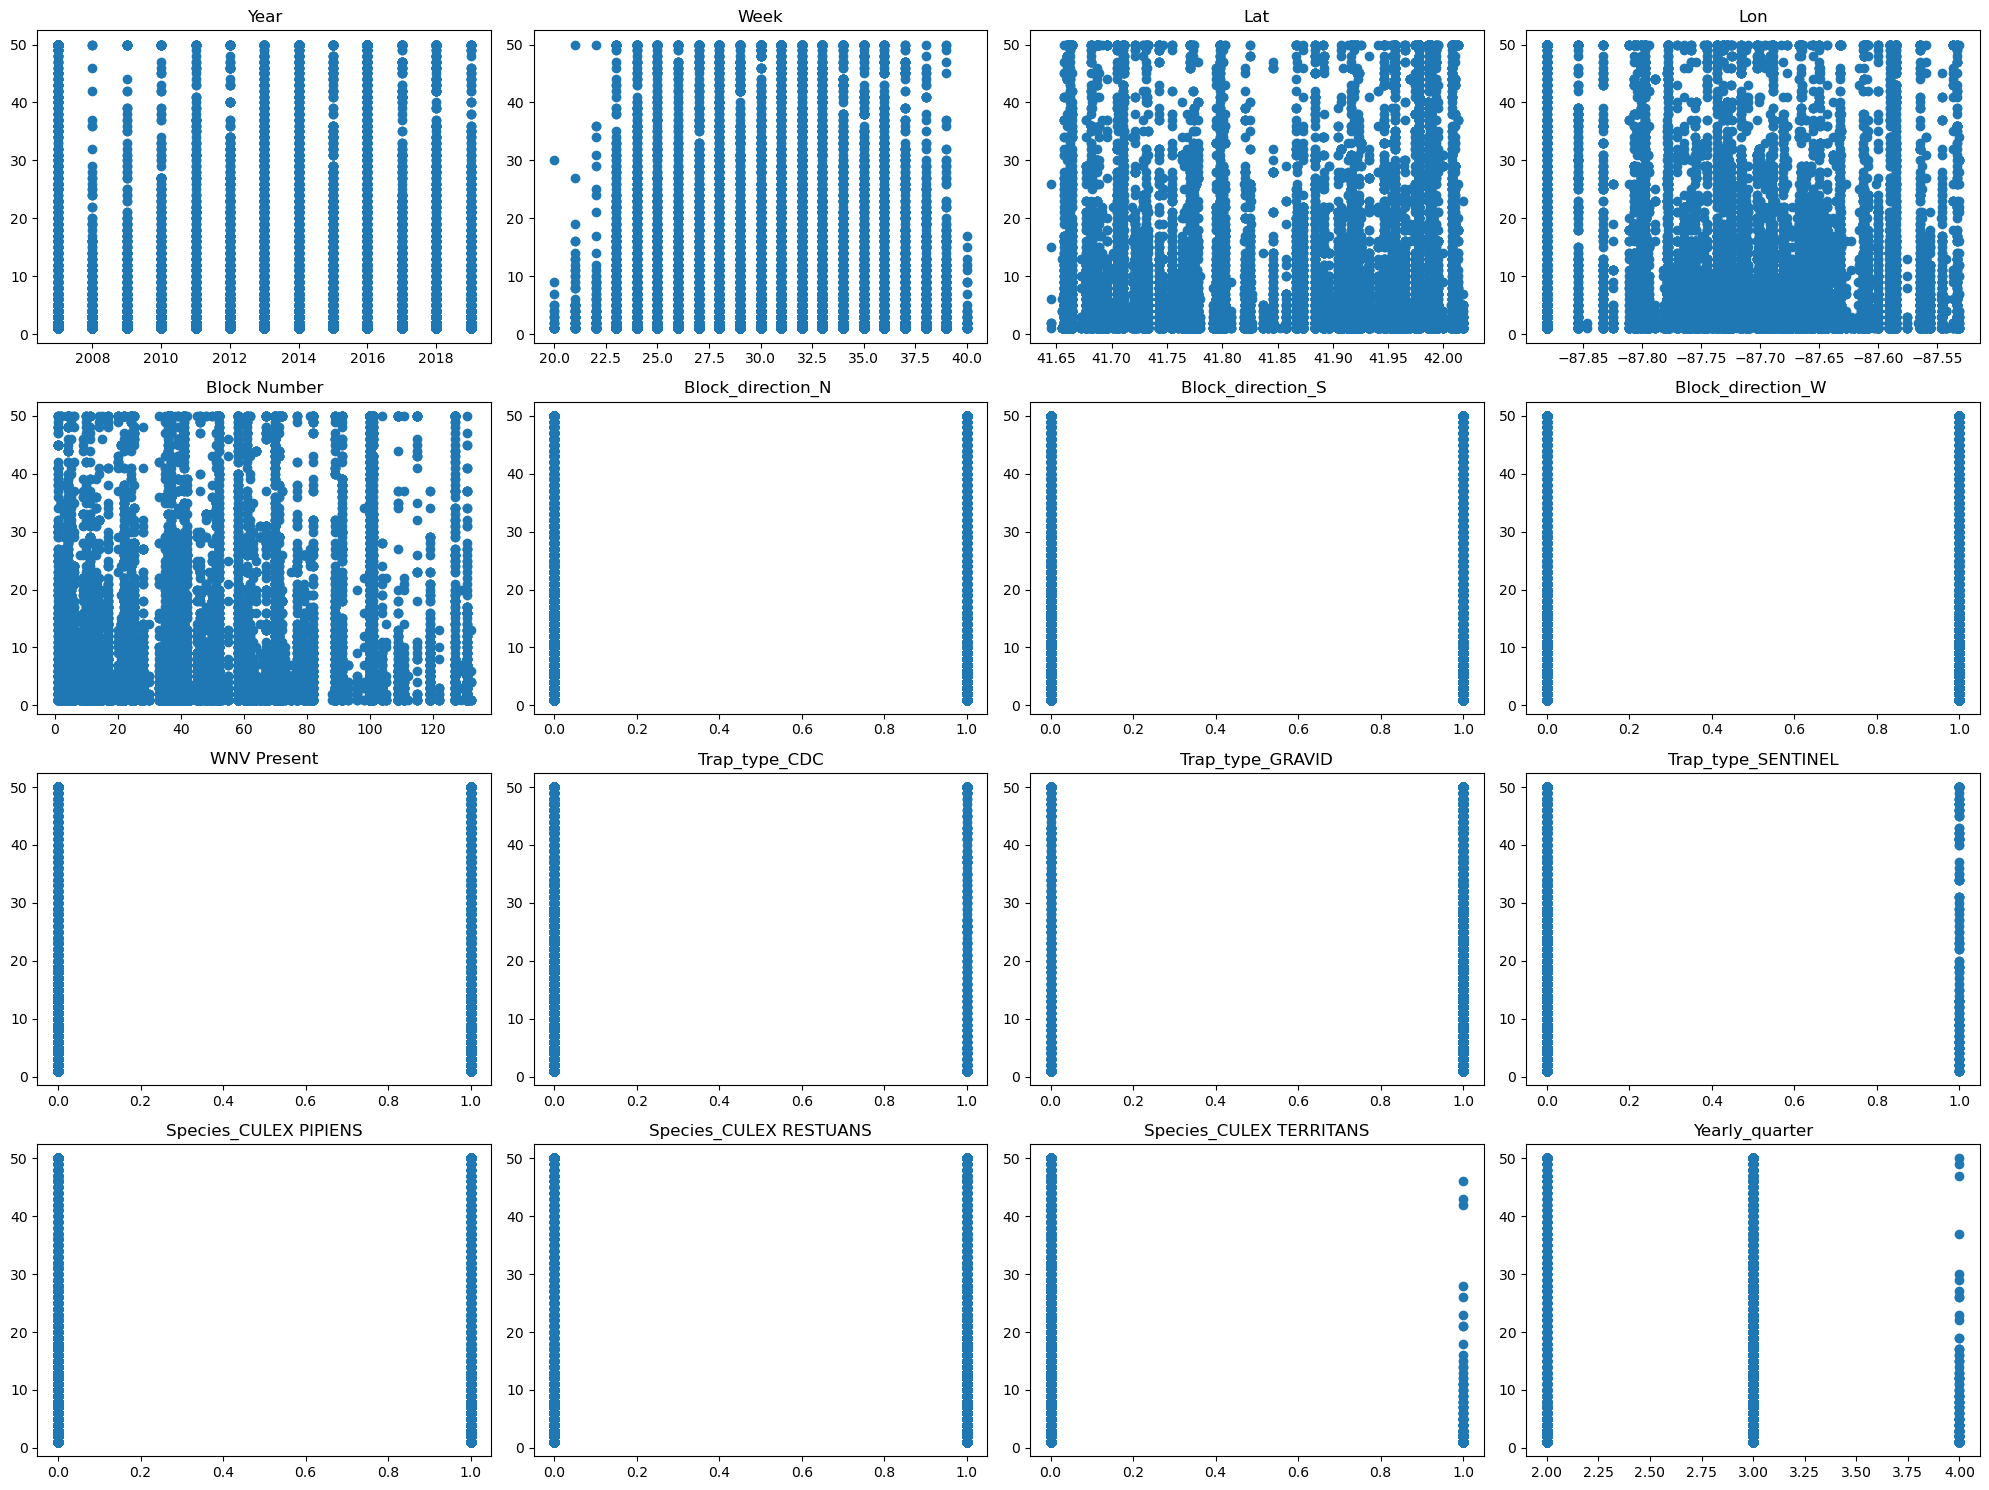

In [62]:
plt.subplots(4, 4, figsize=(20, 15))

count = 1

for col in X.columns:
    plt.subplot(4, 4, count)
    plt.scatter(X[col], y)
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

From the scatter plots, there is no noticeable correlations. It is better to review the Pearson - correlation results again.

In [63]:
df_pearson

,Pearson_correlation,P_value
Variable,,
WNV Present,0.408034,0.0
Year,0.129326,0.0
Block Number,0.121259,0.0
Trap_type_SENTINEL,0.108575,0.0
Lat,0.09682,0.0
Trap_type_CDC,0.094147,0.0
Species_CULEX RESTUANS,0.070999,0.0
Block_direction_N,0.050488,0.0
Species_CULEX PIPIENS,0.01473,0.045152


The above table summarises the correlation factors. Column WNV Present shows the strongest positive correlation (0.41) with the Mosquito number. Year, Block Number, Sentinel, Latitude, CDC, Restuans, Block_direction_N, Pipiens, Block_direction_W and Yearly_quarter all suggest weak positive correlations with the Number of Mosquitos.

Longitude has the strongest negative correlation (-0.15). Territans, Gravid, Salinarius, Block_direction_S and Week all show weak negative correlations. 

Apart from Yearly_quarter and Block_direction_W, all p-values are less than 0.05 and therefore we can confidently accept the correlation values provided (apart from Yearly_quarter and Block_direction_W).

As such, Yearly_quarter and Block_direction_W should be dropped from the predictor variables:

In [64]:
X = X.drop(columns = ['Yearly_quarter','Block_direction_W ', 'WNV Present'])

## Linear Regression

The section above has checked for the Linearity between target and predictor variables. Multicollinearity between predictor variables now needs to be checked.

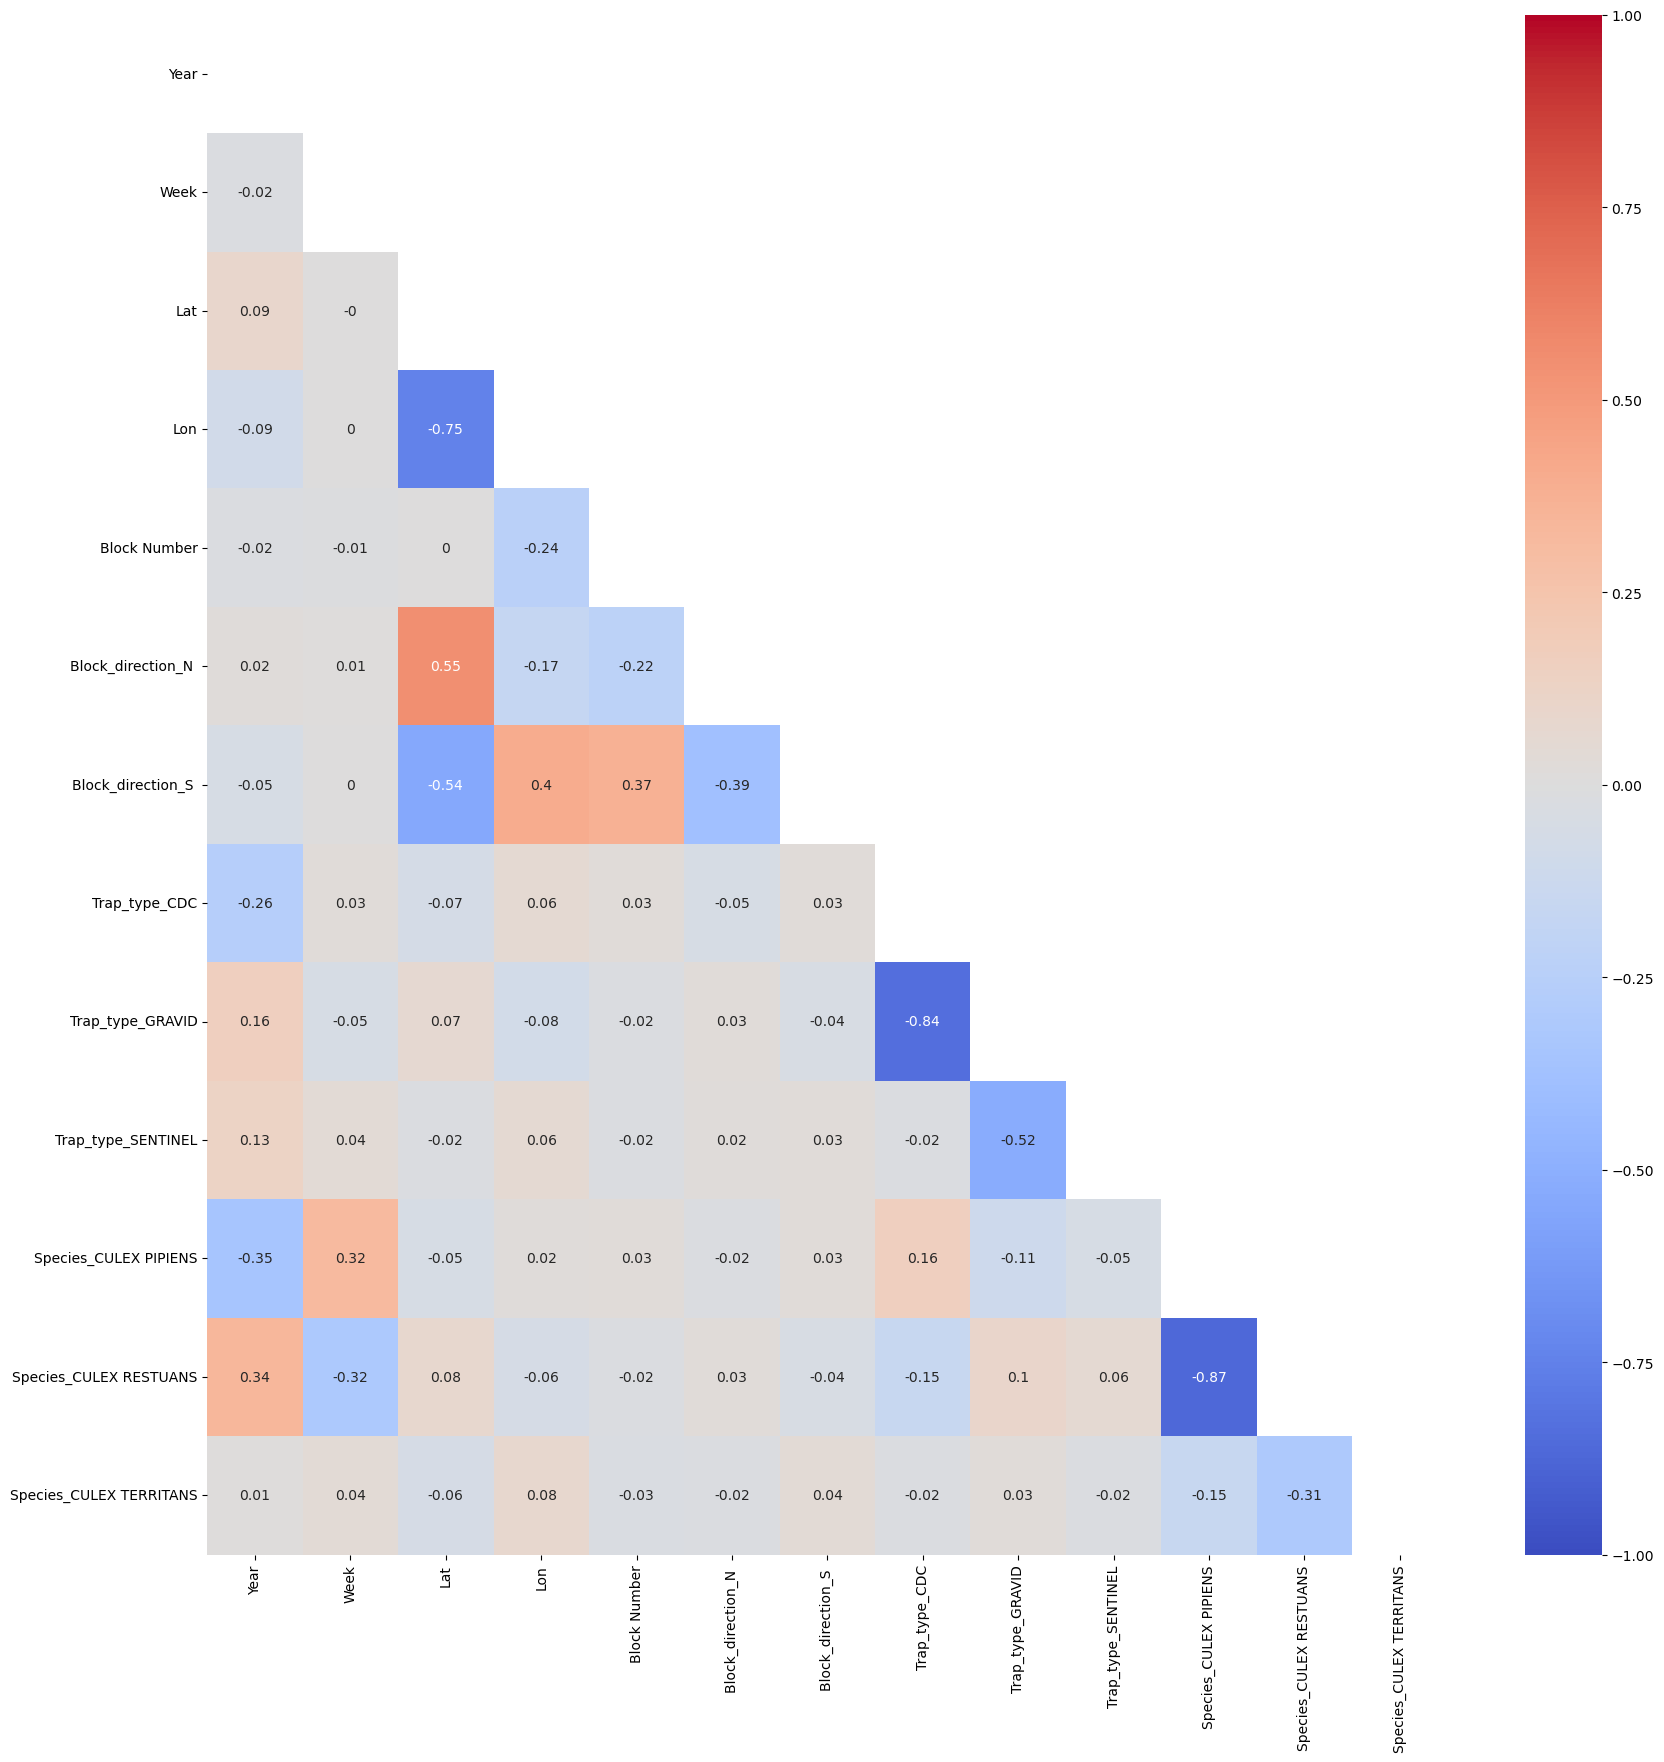

In [65]:
# Heatmap
corr_df = X.corr()

# TRIANGLE MASK
mask = np.triu(corr_df)
# heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(corr_df.round(2), annot = True, vmax = 1, vmin = -1, center = 0, cmap = 'coolwarm', mask = mask)
plt.show()

The above shows the following pairs to be have a concerning degree of mutlicollinearity (>0.5). As such, care needs to be taken when dealing with these pairs in the Linear Regression model:

* Latitude & Longitude
* Block_direction_N & Latitude
* Block_direction_S & Latitude
* Trap Type Gravid & Trap Type CDC
* Trap Type Gravid & Trap Type Sentinel
* Species_CULEX_RESTUANS & SPECIES_CULEX_PIPIENS

#### Building our Linear Regression Model...

In [66]:
from statsmodels.regression import linear_model 
import statsmodels.api as sm

In [67]:
X

,Year,Week,Lat,Lon,Block Number,Block_direction_N,Block_direction_S,Trap_type_CDC,Trap_type_GRAVID,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS
0,2019,39,41.977738,-87.880969,100,0,0,0,1,0,0,1,0
1,2019,39,41.798211,-87.736925,52,0,1,0,1,0,0,1,0
2,2019,39,41.987245,-87.689417,58,1,0,0,1,0,0,1,0
3,2019,39,41.953664,-87.724987,39,1,0,0,1,0,0,1,0
4,2019,39,41.657069,-87.546049,131,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18490,2016,36,41.857843,-87.635858,3,0,0,0,1,0,1,0,0
18491,2007,34,41.965376,-87.758403,46,1,0,0,1,0,1,0,0
18492,2016,30,41.662395,-87.590176,127,0,1,0,1,0,0,1,0
18493,2017,33,41.919197,-87.664758,20,1,0,0,0,1,0,1,0


In [68]:
y

0         2
1         1
2         2
3         1
4         9
         ..
18490     4
18491    19
18492    34
18493    50
18494     6
Name: Mosquito number, Length: 18495, dtype: int64

#### Start by using a Top Down Approach

Dropping the multicollinear columns:

Based on the results from the multicollinearity, the following columns should be dropped:
* Lat
* Trap_type_GRAVID
* Species_CULEX RESTUANS

In [69]:
X = X.drop(columns = ['Lat','Trap_type_GRAVID','Species_CULEX RESTUANS'])

X_cons = sm.add_constant(X)
lin_reg_mod = linear_model.OLS(y,X_cons)
lin_reg_mod_res = lin_reg_mod.fit()
lin_reg_mod_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     201.3
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:28:52   Log-Likelihood:                -73389.
No. Observations:               18495   AIC:                         1.468e+05
Df Residuals:                   18484   BIC:                         1.469e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2195.0264    116.794    -18.794      0.000   -2423.953   -1966.100
Year                        0.5778      0.028     20.556      0.000       0.523       0.633
Week                       -0.1523      0.023     -6.577      0.000      -0.198      -0.107
Lon                       -11.9102      1.219     -9.772      0.000     -14.299      -9.521
Block Number                0.0452      0.003     14.520      0.000       0.039       0.051
Block_direction_N           1.3761      0.232      5.930      0.000       0.921       1.831
Block_direction_S          -1.4583      0.274     -5.325      0.000      -1.995      -0.921
Trap_type_CDC              10.6157      0.580     18.293      0.000       9.478      11.753
Trap_type_SENTINEL         12.8231      0.902     14.213      0.000      11.055      14.592
Species_CULEX PIPIENS       1.5150      0.237      6.384      0.000       1.050       1.980
Species_CULEX TERRITANS    -7.7084      0.443    -17.414      0.000      -8.576      -6.841
==============================================================================
Omnibus:                     4404.978   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8558.433
Skew:                           1.474   Prob(JB):                         0.00
Kurtosis:                       4.554   Cond. No.                     2.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Having dropped all multicolinear predictor variables, the R2 value is 0.098. All p-values are < 0.05 and therefore the remaining variables are statistically significant and should not be dropped.

In [70]:
model_resids = lin_reg_mod_res.resid # this is where the residuals are stored

model_fittedvals = lin_reg_mod_res.fittedvalues # this is where the fitted values are stored

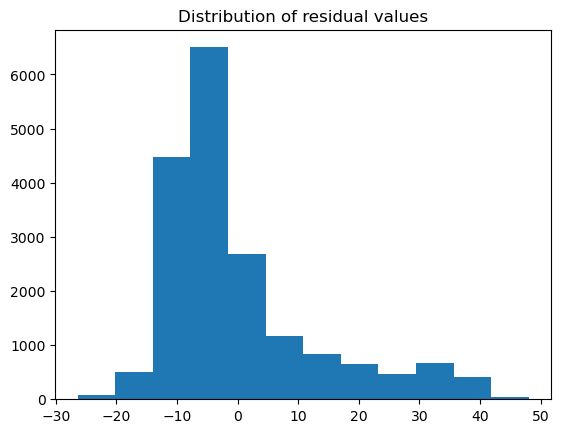

In [71]:
plt.figure()
plt.hist(model_resids, bins = 12)
plt.title('Distribution of residual values')
plt.show()

Looking at a histogram of the residuals from the model, it seems as if they are not normally distributed. Let's check with a Shapiro-Wilk test.

$$ H_0 : \text{Data is normally distributed}  \quad vs. \quad H_1 : \text{Data is not normally distributed} $$

In [72]:
# calculating the shapiro test statisic and its p-value

print("Shapiro-Wilk Test: ", stats.shapiro(lin_reg_mod_res.resid))


Shapiro-Wilk Test:  ShapiroResult(statistic=0.8352473974227905, pvalue=0.0)


/Users/henryparemain/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The pvalue < 0.05 and therefore the null hypothesis should be rejected, and thus reject the statement that the residuals are normally distributed. 

Try a Q-Q plot:

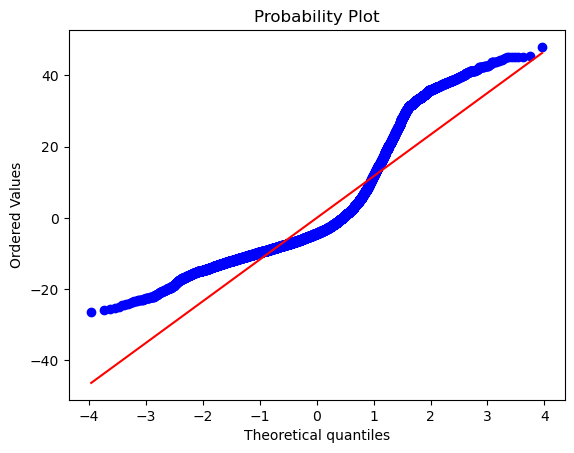

In [73]:
# Normal Q-Q plot

plt.figure()
stats.probplot(lin_reg_mod_res.resid, dist="norm", plot=plt)
plt.show()

There is high deviation of the blue line from the red, showing that the residuals do not follow the behaviour of normally distributed residuals. 

All of the above suggest that the residuals are NOT normally distributed.

Homoscedasticity should be tested, by plotting the residuals against the fitted values.

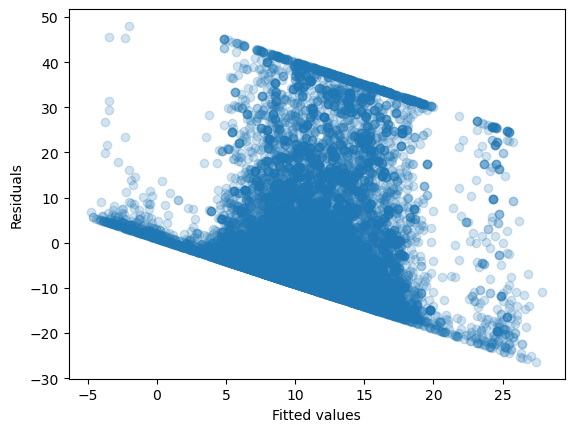

In [74]:
# Plot the residuals and the predicted values
plt.figure()
plt.scatter(lin_reg_mod_res.fittedvalues, lin_reg_mod_res.resid, alpha=0.2)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

The above shows there to be a funneling effect of the residuals vs fitted values. It does not suggest Homoscedastic behaviour, with a strange cut-off happening diagonally. This cut-off is likely due to the fact that mosquito number input was capped at 50.

### Linear Regression Model Summary:

Based on all of the above, it can be concluded that the linear regression model is not an accurate tool to predict the number of mosquitos found in a trap, for the following reasons:

* A low R2 (0.098) meaning the model cannot account for the variance of the data. 
* Both assumptions for linear regression are broken (residuals are not normal or homoscedastic). 

## Logistic Regression

The following section goes through the process of building a Logistic Regression Model, to try to predit the prescence of WNV in a mosquito.

Multicollinearity has already been dealt with in the previous section with variables contributing to multi-collinearity removed. 'Mosquito number' needs to be added back to the dataframe of predictor variables, and multicollinearity rechecked.

In [75]:
X = pd.concat([X,y],axis=1)

In [76]:
X

,Year,Week,Lon,Block Number,Block_direction_N,Block_direction_S,Trap_type_CDC,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX TERRITANS,Mosquito number
0,2019,39,-87.880969,100,0,0,0,0,0,0,2
1,2019,39,-87.736925,52,0,1,0,0,0,0,1
2,2019,39,-87.689417,58,1,0,0,0,0,0,2
3,2019,39,-87.724987,39,1,0,0,0,0,0,1
4,2019,39,-87.546049,131,0,1,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...
18490,2016,36,-87.635858,3,0,0,0,0,1,0,4
18491,2007,34,-87.758403,46,1,0,0,0,1,0,19
18492,2016,30,-87.590176,127,0,1,0,0,0,0,34
18493,2017,33,-87.664758,20,1,0,0,1,0,0,50


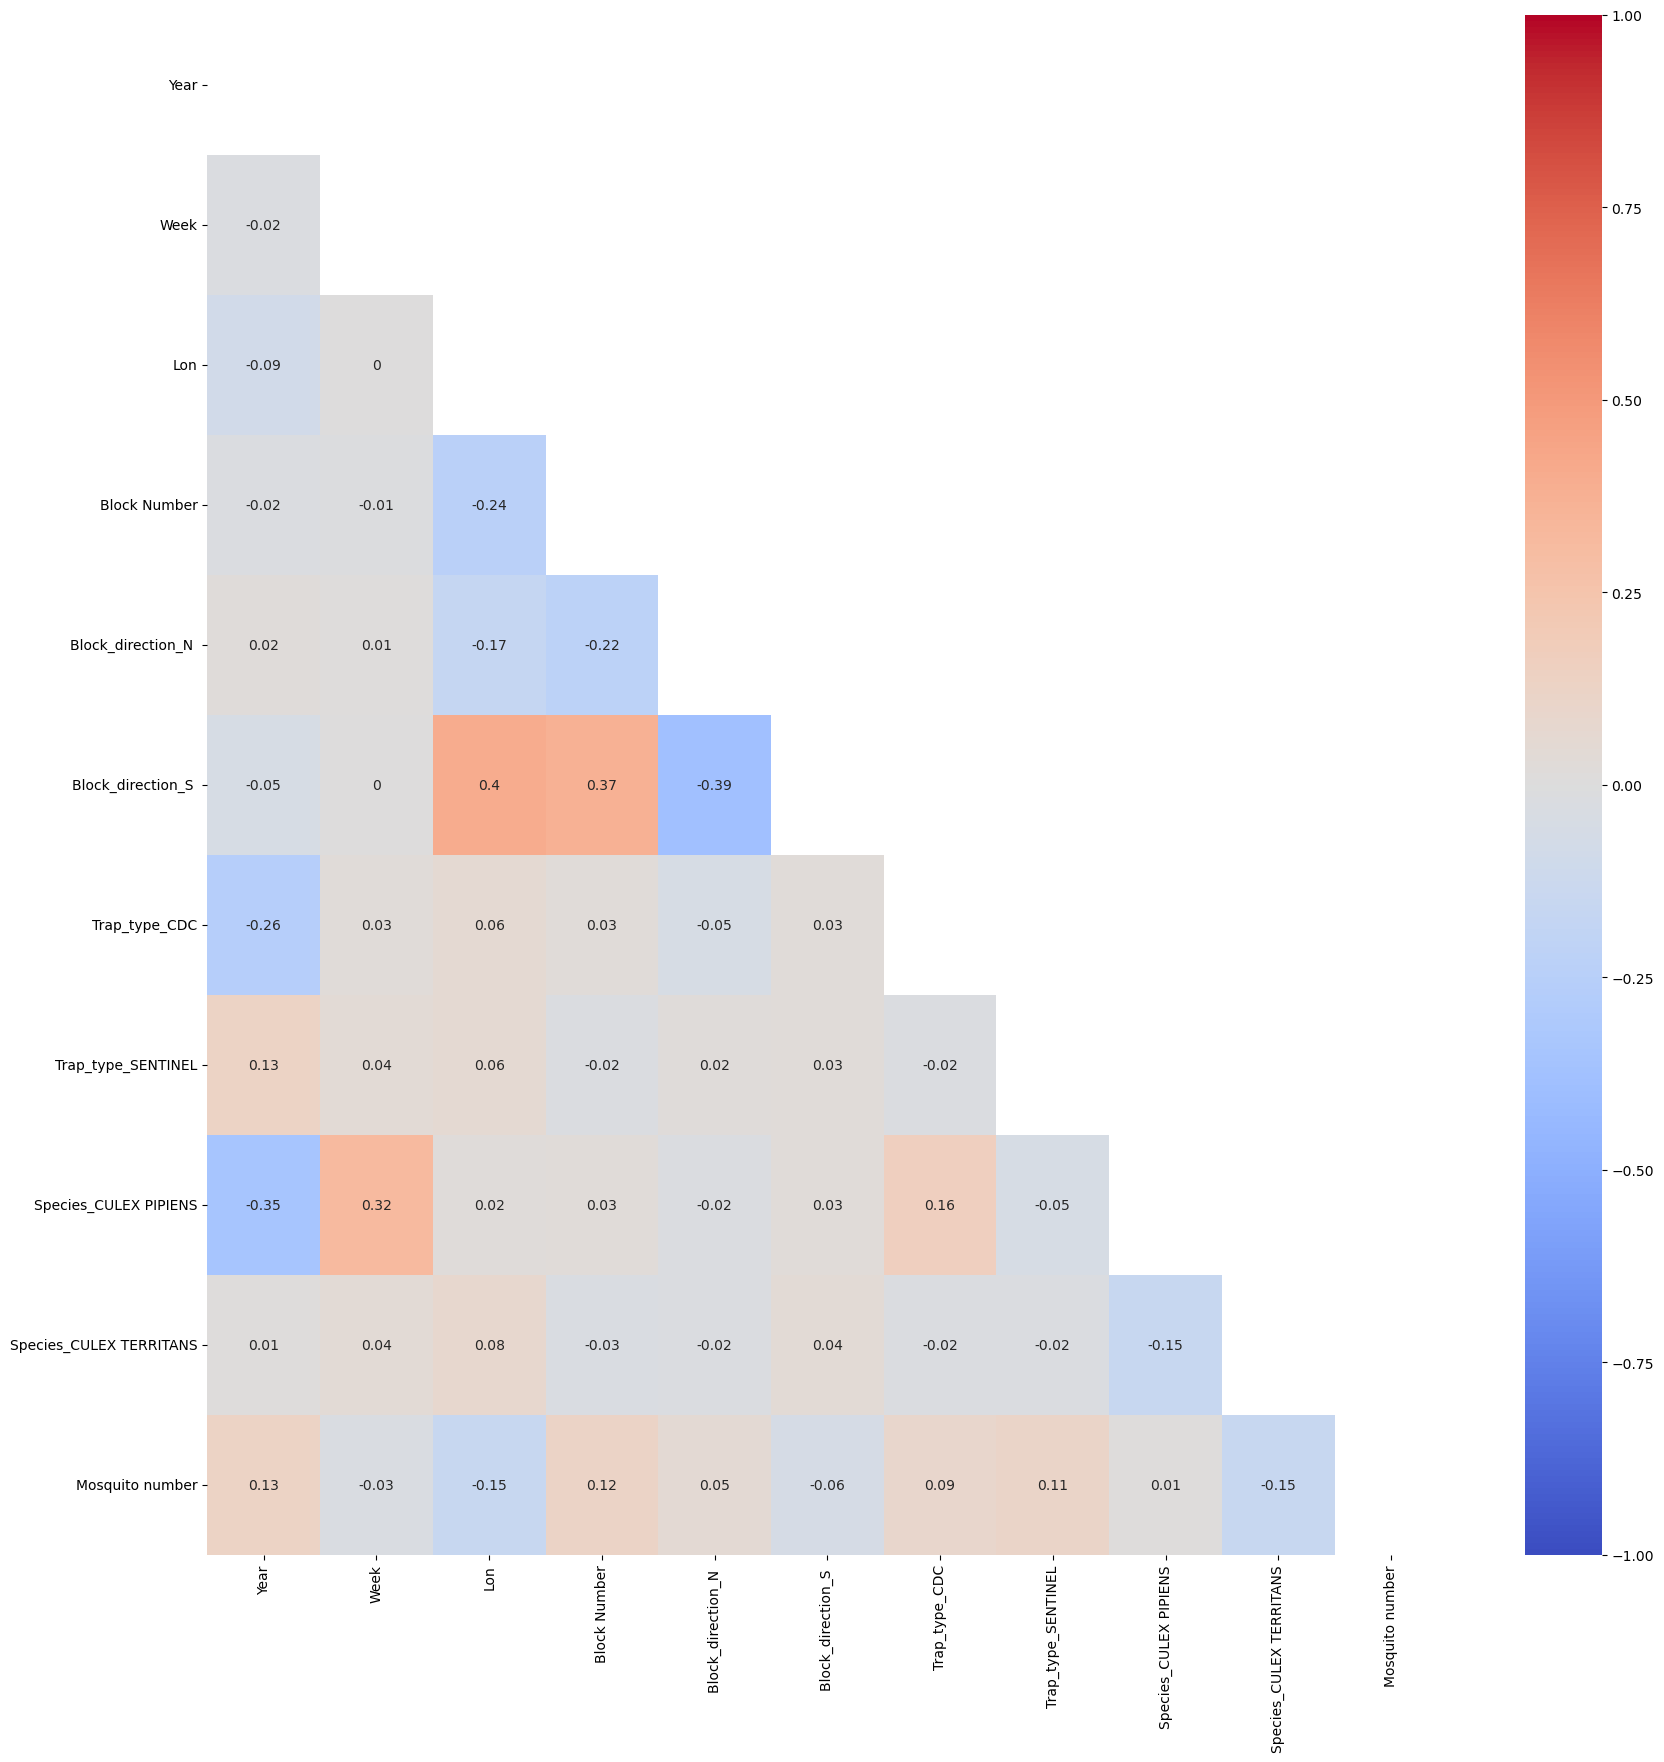

In [77]:
# Heatmap
corr_df = X.corr()

# TRIANGLE MASK
mask = np.triu(corr_df)
# heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(corr_df.round(2), annot = True, vmax = 1, vmin = -1, center = 0, cmap = 'coolwarm', mask = mask)
plt.show()

All correlations are below 0.5 and therefore we can assume multi-collinearity will not be an issue in our model.

### Top down modelling

In [78]:
import statsmodels.api as sm

In [79]:
X.head(5)

,Year,Week,Lon,Block Number,Block_direction_N,Block_direction_S,Trap_type_CDC,Trap_type_SENTINEL,Species_CULEX PIPIENS,Species_CULEX TERRITANS,Mosquito number
0,2019,39,-87.880969,100,0,0,0,0,0,0,2
1,2019,39,-87.736925,52,0,1,0,0,0,0,1
2,2019,39,-87.689417,58,1,0,0,0,0,0,2
3,2019,39,-87.724987,39,1,0,0,0,0,0,1
4,2019,39,-87.546049,131,0,1,0,0,0,0,9


In [80]:
y = df_clean_num['WNV Present']

In [81]:
X_const, logit_mod_fitted = fit_logit_model(X,y)
logit_mod_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.405774
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18483
Method:                           MLE   Df Model:                           11
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                  0.2223
Time:                        10:28:53   Log-Likelihood:                -7504.8
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -531.6737     27.175    -19.565      0.000    -584.935    -478.412
Year                        0.1095      0.007     16.207      0.000       0.096       0.123
Week                        0.1477      0.006     26.101      0.000       0.137       0.159
Lon                        -3.4690      0.276    -12.578      0.000      -4.010      -2.928
Block Number               -0.0021      0.001     -2.946      0.003      -0.003      -0.001
Block_direction_N          -0.0242      0.050     -0.482      0.630      -0.123       0.074
Block_direction_S           0.1290      0.060      2.139      0.032       0.011       0.247
Trap_type_CDC              -0.0998      0.131     -0.760      0.447      -0.357       0.157
Trap_type_SENTINEL         -0.4075      0.170     -2.391      0.017      -0.742      -0.073
Species_CULEX PIPIENS       0.2662      0.051      5.202      0.000       0.166       0.366
Species_CULEX TERRITANS    -2.2400      0.273     -8.194      0.000      -2.776      -1.704
Mosquito number             0.0658      0.001     44.874      0.000       0.063       0.069
===========================================================================================
"""

Let's check the baseline accuracy of our model..

In [82]:
logit_accuracy(X_const,y, logit_mod_fitted)

The model performs with an accuracy = 81.09%


| Model No.  | Predictor Variables   | Accuracy  |
|---|---|---|
| 3.2.1  | All  | 81.09 %   |
|   |   |   |
|   |   |   |

`Block_direction_N` had a high p-value. Let's remove it from this next iteration.

In [83]:
X = X.drop(columns = 'Block_direction_N ')

In [84]:
X_const,logit_mod_fitted = fit_logit_model(X,y)
logit_mod_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.405780
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18484
Method:                           MLE   Df Model:                           10
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                  0.2222
Time:                        10:28:53   Log-Likelihood:                -7504.9
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -531.4451     27.176    -19.556      0.000    -584.709    -478.181
Year                        0.1097      0.007     16.234      0.000       0.096       0.123
Week                        0.1476      0.006     26.099      0.000       0.137       0.159
Lon                        -3.4637      0.276    -12.566      0.000      -4.004      -2.923
Block Number               -0.0020      0.001     -2.908      0.004      -0.003      -0.001
Block_direction_S           0.1365      0.058      2.338      0.019       0.022       0.251
Trap_type_CDC              -0.0963      0.131     -0.735      0.462      -0.353       0.160
Trap_type_SENTINEL         -0.4094      0.170     -2.403      0.016      -0.743      -0.076
Species_CULEX PIPIENS       0.2666      0.051      5.211      0.000       0.166       0.367
Species_CULEX TERRITANS    -2.2398      0.273     -8.194      0.000      -2.776      -1.704
Mosquito number             0.0657      0.001     44.956      0.000       0.063       0.069
===========================================================================================
"""

In [85]:
logit_accuracy(X_const,y, logit_mod_fitted)

The model performs with an accuracy = 81.11%


| Model No.  | Predictor Variables   | Accuracy  |
|---|---|---|
| 3.2.1  | All  | 81.09 %   |
| 3.2.2 | `Block_direction_N` removed  | 81.09%  |
|   |   |   |

`Trap_type_CDC` had a high p-value. Let's remove it from this next iteration.

In [86]:
X = X.drop(columns = 'Trap_type_CDC')

In [87]:
X_const,logit_mod_fitted = fit_logit_model(X,y)
logit_mod_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.405795
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18485
Method:                           MLE   Df Model:                            9
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                  0.2222
Time:                        10:28:53   Log-Likelihood:                -7505.2
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -536.0380     26.468    -20.252      0.000    -587.915    -484.161
Year                        0.1109      0.007     16.964      0.000       0.098       0.124
Week                        0.1475      0.006     26.095      0.000       0.136       0.159
Lon                        -3.4871      0.274    -12.734      0.000      -4.024      -2.950
Block Number               -0.0021      0.001     -2.979      0.003      -0.003      -0.001
Block_direction_S           0.1369      0.058      2.345      0.019       0.022       0.251
Trap_type_SENTINEL         -0.4079      0.170     -2.397      0.017      -0.741      -0.074
Species_CULEX PIPIENS       0.2643      0.051      5.175      0.000       0.164       0.364
Species_CULEX TERRITANS    -2.2411      0.273     -8.199      0.000      -2.777      -1.705
Mosquito number             0.0656      0.001     45.511      0.000       0.063       0.068
===========================================================================================
"""

In [88]:
logit_accuracy(X_const,y, logit_mod_fitted)

The model performs with an accuracy = 81.17%


| Model No.  | Predictor Variables   | Accuracy  |
|---|---|---|
| 3.2.1  | All  | 81.09 %   |
| 3.2.2 | `Block_direction_N` removed  | 81.09%  |
|  3.3.3 | `Trap_type_CDC` removed  | 81.09%  |

All of the p-values in the model are now below 0.05 and are therefore statistically significant. No more variables need to be dropped and the model accuracy has plateaued at 81.09%.

#### Model Evaluation

<AxesSubplot:>

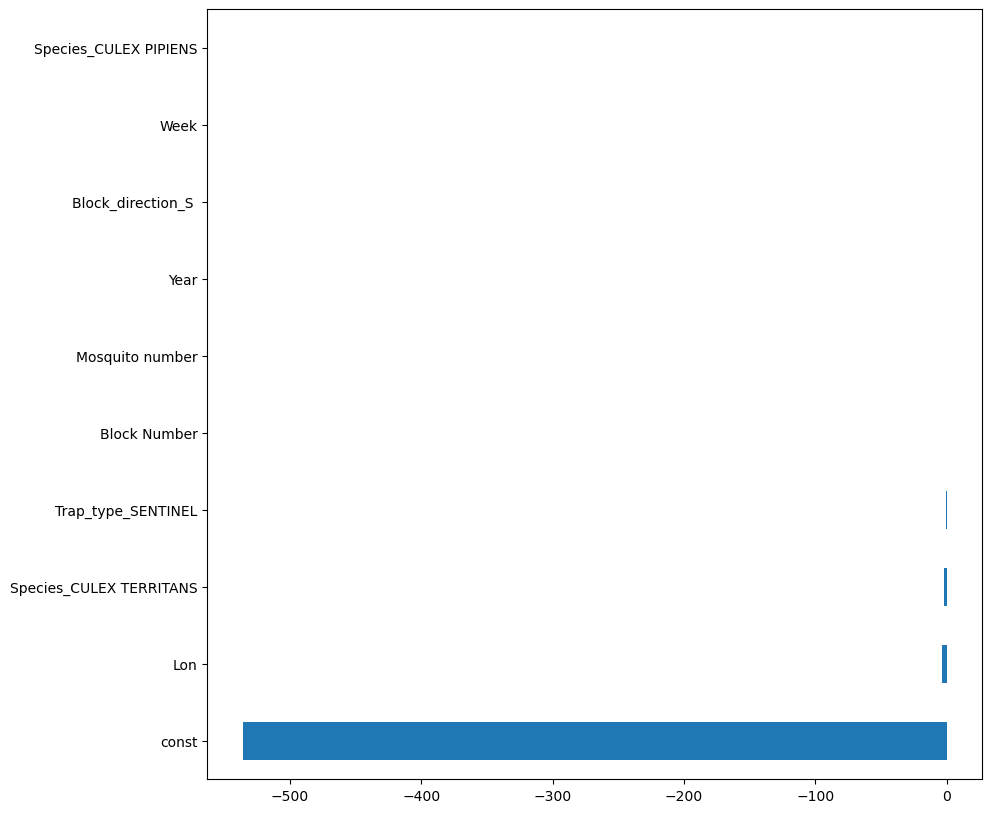

In [89]:
plt.figure(figsize = (10, 10))
logit_mod_fitted.params.sort_values().plot(kind = 'barh')

The above graph is skewed by the much larger coefficient of the constant. Repeat without the const value...

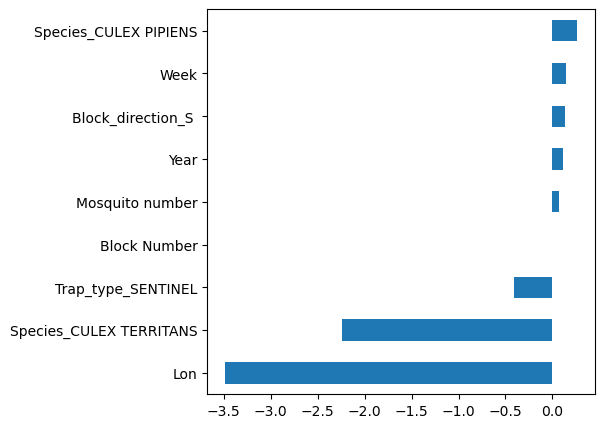

In [90]:
# Model coefficients (i.e. the betas)
params_series = logit_mod_fitted.params

params_series.drop('const', inplace=True)

plt.figure(figsize=(5,5))
params_series.sort_values().plot(kind='barh')
plt.show()

A more useful metric is to look at the odds change...

In [91]:
coefficients_df = pd.DataFrame({'coeff': logit_mod_fitted.params, 
                                'p-values': round(logit_mod_fitted.pvalues, 2),
                               'odds change': np.exp(logit_mod_fitted.params)})
coefficients_df.reset_index(inplace = True)
coefficients_df.rename({'index':'variable'}, axis='columns', inplace=True)


coefficients_df = coefficients_df.sort_values(by='odds change', ascending=True)
coefficients_df

,variable,coeff,p-values,odds change
0,const,-536.038047,0.00,1.590868e-233
3,Lon,-3.487148,0.00,3.058798e-02
8,Species_CULEX TERRITANS,-2.241065,0.00,1.063452e-01
6,Trap_type_SENTINEL,-0.407914,0.02,6.650361e-01
4,Block Number,-0.002068,0.00,9.979338e-01
9,Mosquito number,0.065551,0.00,1.067747e+00
1,Year,0.110918,0.00,1.117304e+00
5,Block_direction_S,0.136872,0.02,1.146681e+00
2,Week,0.147480,0.00,1.158910e+00
7,Species_CULEX PIPIENS,0.264322,0.00,1.302547e+00


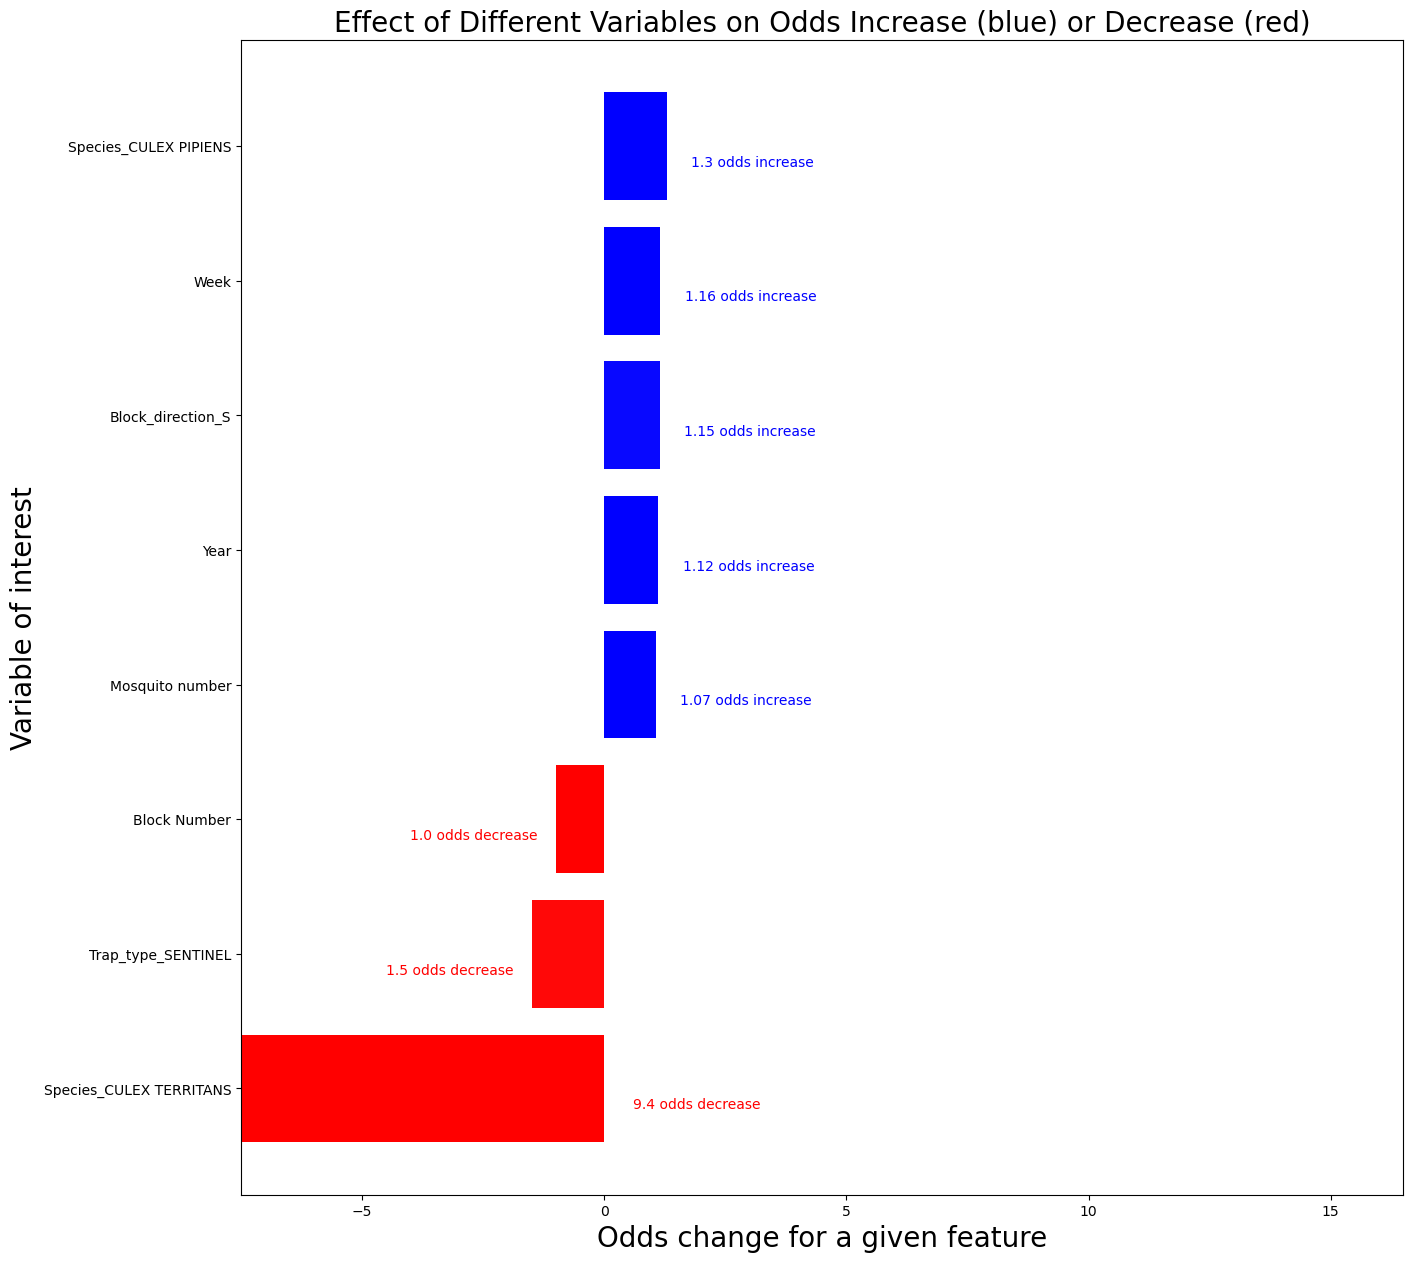

In [92]:
categories = []    # Holds labels for bars
sizes = []         # Hold bar heights
colors = []        # Holds bar colors
p_values = []      # Used for additional text within the plot

p_value_color_scale = 1.5

# iterate through
for index, row in coefficients_df.iterrows():
    variable_name = row['variable'].strip()
    
    if (variable_name != 'const' and variable_name!='Lon'):   # We don't care much for the constant since we can modify it
        
        
        categories.append(variable_name)
        coefficient_value = row['coeff']
        
        p_value = round(row['p-values'],2)
        p_values.append(p_value)
        


        color = [1.0,1.0,1.0]
        
        color[1] = (min(p_value_color_scale*p_value, 1.0)/1.0)  # Make GREEN brighter
        
        if (coefficient_value >= 0):
            color[0] = color[1]                     # Make RED brighter
            column_size = np.exp(coefficient_value)
        else:
            color[2] = color[1]                     # Make BLUE brighter
            column_size = -1/np.exp(coefficient_value)

        column_size = round(column_size,2)
        sizes.append(column_size)
        colors.append(color)


fix, ax = plt.subplots(figsize=(15, 15))
ax.barh(categories, sizes, color=colors)
for index, bar_size in enumerate(sizes):
    if (bar_size > 0.0):
        # Add a label text
        ax.text(bar_size + 0.5, index-0.15, f'{bar_size} odds increase', color='blue')
        
        # Add a p-value disclaimer
        if (p_values[index] >= 0.05):
            ax.text(-2.5, index-0.15, f'p-value={p_values[index]}', color='blue')
    else:
        # Label text
        if bar_size < -5:
            ax.text(bar_size +10, index-0.15, f'{abs(bar_size)} odds decrease', color='red')
        else:
            ax.text(bar_size -3, index-0.15, f'{abs(bar_size)} odds decrease', color='red')
        
        # p-value disclaimer
        if (p_values[index] >= 0.05):
            ax.text(0.3, index - 0.15, f'p-value={p_values[index]}', color='red')

# change the limit to make sure labels go inside the plot area
plt.xlim(-7.5, 16.5)
plt.title("Effect of Different Variables on Odds Increase (blue) or Decrease (red)" ,size=20)
plt.xlabel("Odds change for a given feature", size=20)
plt.ylabel("Variable of interest", size=20)
plt.show()

#### Model Conclusions:

The above graph shows that variable with the greatest predicting power of increasing the odds of a mosquito being positive with WNV is whether the species is Culex Pipiens. The variable with the greatest predicting power of decreasing the odds of a mosquito being positive is whether the species is Culex Territans.

These findings back up the initial findings carried out in SAPH1, which saw Pipiens to have the highest % of WNV cases of all species, as well as the hypothesis testing carried out in Part 2.1 of this report. 

The Blocks further South seem to increase the odds of a Positive case, suggesting that there is a greater prevalence of the virus in the South of Chiacago.

The final model has an 81% accuracy in predicting if a mosquito is WNV positive or negative.